# 🚀 Guia Completo e Prático: Lidando com Relações Não-Lineares nas Features

Neste notebook, faremos um mergulho profundo nas técnicas para modelar relações não-lineares entre variáveis. O foco é em cenários onde o **modelo continua linear nos seus parâmetros**, mas a relação com as variáveis de entrada (features) não é uma linha reta.

Partiremos do básico (Regressão Polinomial) e avançaremos para soluções mais flexíveis e poderosas como Splines e Modelos Aditivos Generalizados (GAMs), sempre comparando as abordagens e discutindo os prós e contras de cada uma.

**Objetivo:** Entender e aplicar diferentes métodos para capturar não-linearidades, desde a engenharia de features manual até o uso de modelos mais avançados.


In [1]:

# --- Imports Essenciais ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para modelagem e métricas com Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Instalação e Import do PyGAM para Splines ---
from pygam import LinearGAM, s, f

# --- Configurações de Visualização ---
# Define um estilo visual mais agradável para os gráficos
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 8)

print("✅ Ambiente configurado com sucesso!")

✅ Ambiente configurado com sucesso!


## Seção 1: O Ponto de Partida - Regressão Polinomial

Iniciamos nossa exploração com o cenário mais clássico de não-linearidade: uma relação polinomial.

### 1.1. O Desafio: Uma Relação Quadrática

Vamos simular um conjunto de dados onde a variável alvo (`y`) tem uma relação em forma de "U" com a feature (`X`). Este tipo de padrão é comum em diversas áreas. Por exemplo, pode representar:
* O custo de produção por unidade, que diminui com a eficiência e depois aumenta devido à sobrecarga de capacidade.
* O efeito de um nutriente no crescimento de uma planta, onde pouco é ineficaz e muito se torna tóxico.

Criaremos os dados seguindo a equação de uma parábola, com um pouco de ruído aleatório para torná-los mais realistas:

$$ y = 0.8x^2 - 1.5x + 2 + \text{ruído} $$

O objetivo é visualizar esse padrão e confirmar que uma linha reta não será suficiente para descrevê-lo.

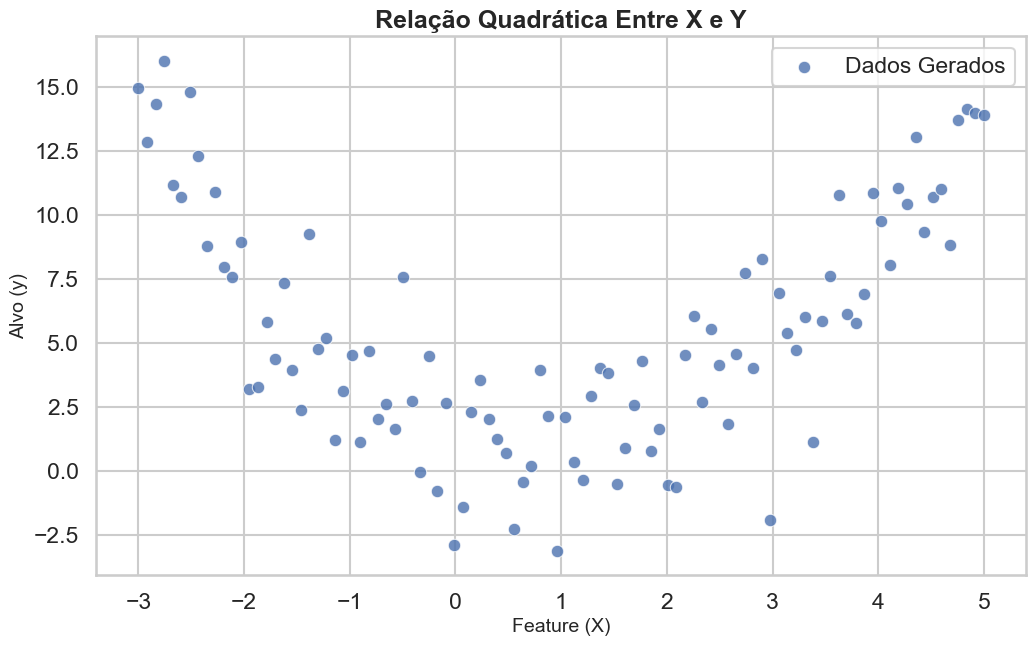

In [2]:
# Semente aleatória para garantir que os resultados sejam reprodutíveis
np.random.seed(42)

# 1. Geração dos dados
# Criamos 100 pontos para a feature X, distribuídos uniformemente entre -3 e 5
X = np.linspace(-3, 5, 100).reshape(-1, 1)

# Definimos os coeficientes da nossa equação quadrática
a = 0.8
b = -1.5
c = 2

# Calculamos y usando a equação e adicionamos um ruído gaussiano (aleatório)
# O ruído simula as imperfeições e a variabilidade do mundo real
noise = np.random.normal(0, 2.5, X.shape[0]).reshape(-1, 1)
y = (a * X**2 + b * X + c) + noise

# 2. Visualização dos dados
plt.figure(figsize=(12, 7))
sns.scatterplot(x=X.flatten(), y=y.flatten(), s=80, alpha=0.8, label='Dados Gerados')

# Títulos e legendas para clareza
plt.title('Relação Quadrática Entre X e Y', fontsize=18, fontweight='bold')
plt.xlabel('Feature (X)', fontsize=14)
plt.ylabel('Alvo (y)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 1.2. A Abordagem Ingênua: Falha da Regressão Linear Simples

A Regressão Linear busca encontrar a **melhor linha reta** que se ajusta aos dados.

Nossa hipótese é que o modelo terá um desempenho ruim, pois uma única linha reta é incapaz de capturar a curvatura presente na relação entre `X` e `y`. Este fenômeno é conhecido como **underfitting** (ou sub-ajuste), onde o modelo é simples demais para a complexidade dos dados.

Analisaremos tanto o resultado visual quanto as métricas de erro (MSE) e de ajuste (R²).

--- Desempenho do Modelo Linear Simples ---
Erro Quadrático Médio (MSE): 21.33
Coeficiente de Determinação (R²): 0.01
-----------------------------------------

O R² baixo indica que o modelo explica muito pouco da variabilidade dos dados.


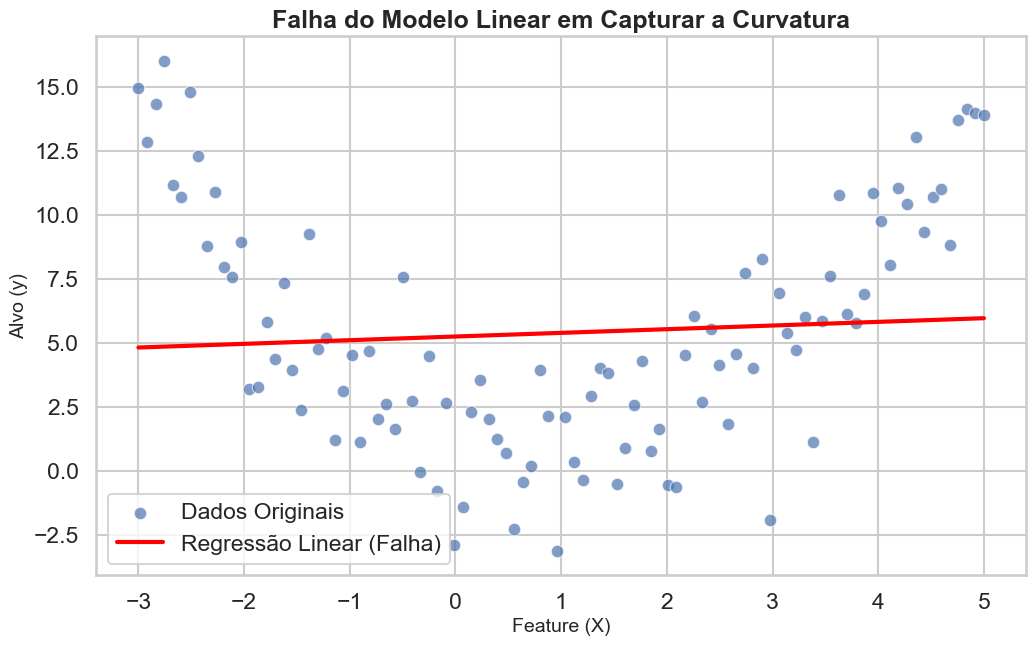

In [3]:
# 1. Criar e treinar o modelo de Regressão Linear
# Instanciamos o modelo
linear_regression_model = LinearRegression()

# Treinamos o modelo com nossos dados X e y
linear_regression_model.fit(X, y)

# 2. Fazer previsões com o modelo treinado
y_pred_linear = linear_regression_model.predict(X)

# 3. Calcular as métricas de desempenho
mse_linear = mean_squared_error(y, y_pred_linear)
r2_linear = r2_score(y, y_pred_linear)

# Exibir os resultados das métricas
print("--- Desempenho do Modelo Linear Simples ---")
print(f"Erro Quadrático Médio (MSE): {mse_linear:.2f}")
print(f"Coeficiente de Determinação (R²): {r2_linear:.2f}")
print("-----------------------------------------")
print("\nO R² baixo indica que o modelo explica muito pouco da variabilidade dos dados.")

# 4. Visualizar o resultado
plt.figure(figsize=(12, 7))

# Plotar os dados originais
sns.scatterplot(x=X.flatten(), y=y.flatten(), s=80, alpha=0.7, label='Dados Originais')

# Plotar a linha da regressão linear
plt.plot(X, y_pred_linear, color='red', linewidth=3, label='Regressão Linear (Falha)')

# Títulos e legendas
plt.title('Falha do Modelo Linear em Capturar a Curvatura', fontsize=18, fontweight='bold')
plt.xlabel('Feature (X)', fontsize=14)
plt.ylabel('Alvo (y)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 1.3. A Solução Clássica: `PolynomialFeatures` 💡

Se o problema é que uma linha reta é insuficiente, a solução é permitir que nosso modelo crie uma curva. Conseguimos isso não trocando o modelo, mas sim **adicionando novas features** que são versões polinomiais da feature original.


O truque genial é que o modelo de regressão linear continuará o mesmo. Ele apenas verá mais de uma feature de entrada (`X` e `X²`). O modelo que ele ajustará será:

$$ y = \beta_0 + \beta_1 X + \beta_2 X^2 $$

Note que esta equação **é não-linear em relação à feature X**, mas continua sendo **perfeitamente linear em relação aos parâmetros** $\beta_0, \beta_1, \beta_2$. Por isso, ainda podemos usar `LinearRegression` para encontrar os coeficientes ótimos. Estamos, na prática, ajustando uma parábola aos dados.

In [4]:
# 1. Criar o transformador de features polinomiais
# degree=2 vai criar features até X² (X¹, X²)
# include_bias=False para não adicionar a coluna de '1's, pois o LinearRegression já cuida do intercepto.
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# 2. Transformar nossa feature X original
X_poly = poly_features.fit_transform(X)

# Vamos inspecionar as dimensões para entender o que aconteceu
print(f"Shape do X original: {X.shape}")
print(f"Shape do X transformado (X_poly): {X_poly.shape}")
print("A nova matriz contém a feature original (X¹) e a nova feature quadrática (X²).")

# 3. Treinar um novo modelo linear com as features transformadas
polynomial_regression_model = LinearRegression()
polynomial_regression_model.fit(X_poly, y)

Shape do X original: (100, 1)
Shape do X transformado (X_poly): (100, 2)
A nova matriz contém a feature original (X¹) e a nova feature quadrática (X²).


LinearRegression()

--- Desempenho do Modelo Polinomial (Grau 2) ---
Erro Quadrático Médio (MSE): 5.07 (Melhora drástica!)
Coeficiente de Determinação (R²): 0.76 (Agora explica quase toda a variância!)
--------------------------------------------------


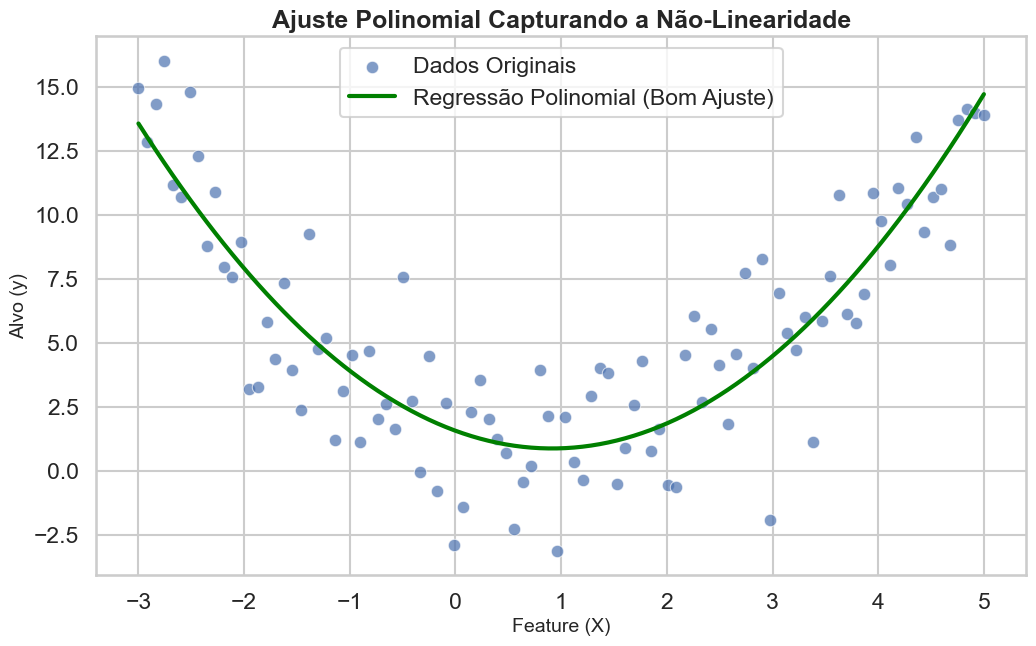

In [5]:
# 1. Fazer previsões com o modelo polinomial
y_pred_poly = polynomial_regression_model.predict(X_poly)

# 2. Calcular as novas métricas de desempenho
mse_poly = mean_squared_error(y, y_pred_poly)
r2_poly = r2_score(y, y_pred_poly)

# Exibir os resultados e comparar com o modelo anterior
print("--- Desempenho do Modelo Polinomial (Grau 2) ---")
print(f"Erro Quadrático Médio (MSE): {mse_poly:.2f} (Melhora drástica!)")
print(f"Coeficiente de Determinação (R²): {r2_poly:.2f} (Agora explica quase toda a variância!)")
print("--------------------------------------------------")

# 3. Visualizar o resultado do novo modelo
plt.figure(figsize=(12, 7))

# Plotar os dados originais
sns.scatterplot(x=X.flatten(), y=y.flatten(), s=80, alpha=0.7, label='Dados Originais')

# Plotar a curva do modelo polinomial
# É importante ordenar os valores de X para que a linha seja desenhada corretamente
sorted_zip = sorted(zip(X, y_pred_poly))
X_sorted, y_poly_sorted = zip(*sorted_zip)
plt.plot(X_sorted, y_poly_sorted, color='green', linewidth=3, label='Regressão Polinomial (Bom Ajuste)')

# Títulos e legendas
plt.title('Ajuste Polinomial Capturando a Não-Linearidade', fontsize=18, fontweight='bold')
plt.xlabel('Feature (X)', fontsize=14)
plt.ylabel('Alvo (y)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 1.4. O Perigo do Excesso: Overfitting com Polinômios de Grau Elevado ⚠️

Vimos que aumentar a complexidade do modelo (de grau 1 para 2) melhorou drasticamente nosso resultado. Uma pergunta natural seria: "E se aumentarmos ainda mais o grau do polinômio? O modelo ficará cada vez melhor?"

A resposta é **não**. Existe um ponto onde a complexidade se vira contra nós.

Ao usar um grau muito alto, o modelo se torna tão flexível que ele não aprende mais o padrão geral dos dados. Em vez disso, ele começa a "decorar" os pontos de treino, incluindo o ruído aleatório (**overfitting**). 


In [6]:
# 1. Definir um grau polinomial muito alto
high_degree = 15

# 2. Criar as features polinomiais de grau 15
poly_features_overfit = PolynomialFeatures(degree=high_degree, include_bias=False)
X_overfit = poly_features_overfit.fit_transform(X)

# 3. Treinar o modelo de regressão linear com essas features
overfitted_linear_regression = LinearRegression()
overfitted_linear_regression.fit(X_overfit, y)

# 4. Fazer as previsões
y_pred_overfit = overfitted_linear_regression.predict(X_overfit)

# Calcular o R² nos dados de treino. Ele será enganosamente alto!
r2_overfit = r2_score(y, y_pred_overfit)
print(f"R² do modelo de grau {high_degree} (nos dados de treino): {r2_overfit:.4f}")
print("O R² é quase perfeito, mas o modelo é instável e inútil na prática.")

R² do modelo de grau 15 (nos dados de treino): 0.7950
O R² é quase perfeito, mas o modelo é instável e inútil na prática.


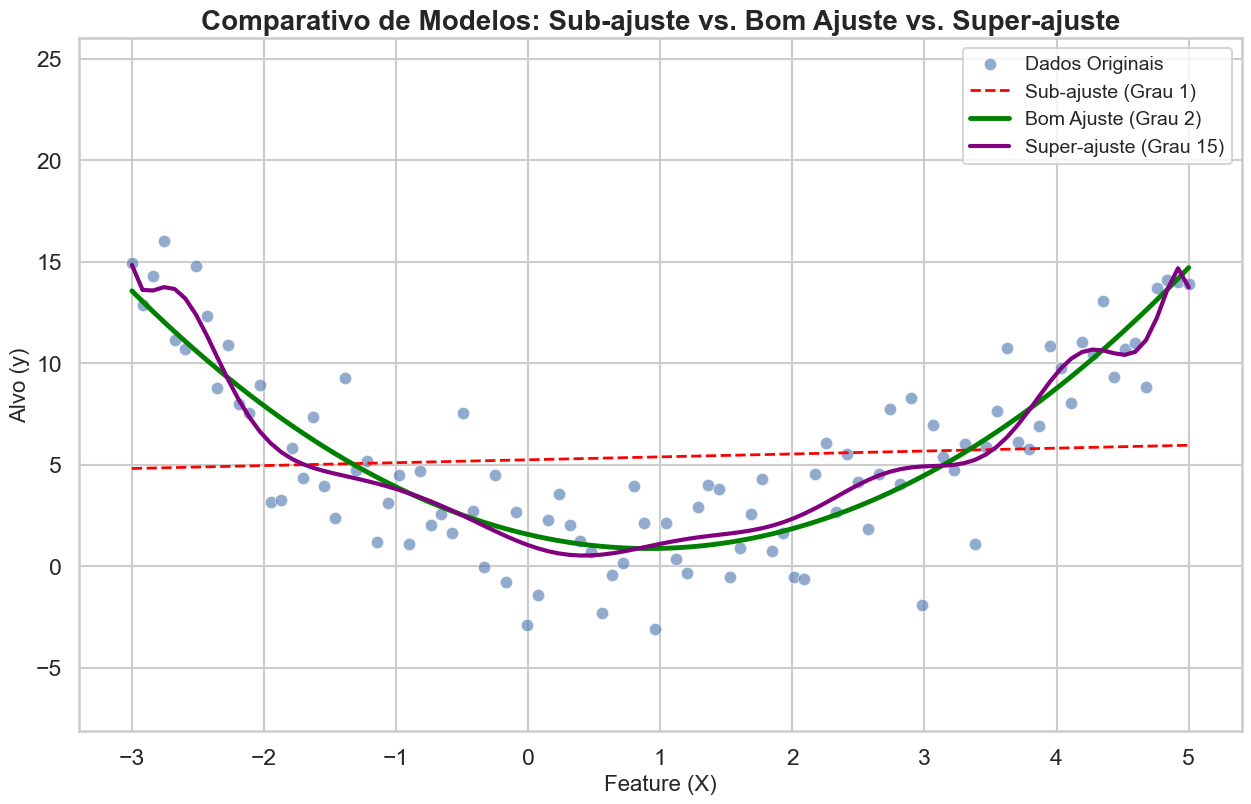

In [7]:
# Criar o gráfico comparativo final
plt.figure(figsize=(15, 9))

# Plotar os dados originais
sns.scatterplot(x=X.flatten(), y=y.flatten(), s=80, alpha=0.6, label='Dados Originais')

# Plotar os 3 modelos
# Modelo 1: Sub-ajuste (Linear)
plt.plot(X, y_pred_linear, color='red', linewidth=2, linestyle='--', label='Sub-ajuste (Grau 1)')

# Modelo 2: Bom Ajuste (Polinomial Grau 2)
# Reutilizando a ordenação da seção anterior para plotar a curva corretamente
sorted_zip_good = sorted(zip(X, y_pred_poly))
X_sorted_good, y_poly_sorted_good = zip(*sorted_zip_good)
plt.plot(X_sorted_good, y_poly_sorted_good, color='green', linewidth=3.5, label='Bom Ajuste (Grau 2)')

# Modelo 3: Super-ajuste (Polinomial Grau 15)
sorted_zip_overfit = sorted(zip(X, y_pred_overfit))
X_sorted_overfit, y_poly_sorted_overfit = zip(*sorted_zip_overfit)
plt.plot(X_sorted_overfit, y_poly_sorted_overfit, color='purple', linewidth=3, label=f'Super-ajuste (Grau {high_degree})')

# Limitar o eixo Y para melhor visualização, pois as oscilações podem ser muito grandes
plt.ylim(min(y) - 5, max(y) + 10)

# Títulos e legendas
plt.title('Comparativo de Modelos: Sub-ajuste vs. Bom Ajuste vs. Super-ajuste', fontsize=20, fontweight='bold')
plt.xlabel('Feature (X)', fontsize=16)
plt.ylabel('Alvo (y)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

#### Conclusão da Seção 1

O gráfico acima é a principal lição desta seção.

* O **modelo linear (vermelho)** é muito rígido e falha em capturar a tendência óbvia dos dados.
* O **modelo quadrático (verde)** é "na medida certa" (o chamado *good fit*), capturando a estrutura da parábola sem se preocupar com o ruído aleatório.
* O **modelo de grau 15 (roxo)** é excessivamente flexível. Ele se contorce de forma bizarra para passar o mais perto possível de cada ponto, resultando em oscilações extremas, especialmente nas bordas dos dados. Esse modelo não generaliza e seria inútil para prever novos pontos.

**Conclusão:** Regressão Polinomial é uma ferramenta poderosa para relações curvas simples, mas é fundamental escolher um grau que represente a tendência geral sem tentar "decorar" o ruído. Encontrar esse equilíbrio é o cerne do desafio da modelagem.

## Seção 2: Relações Monotônicas - O Poder das Transformações

Nem toda relação curva é uma parábola ou tem múltiplos picos e vales. Muitas vezes, encontramos relações que sempre crescem ou sempre decrescem, mas a uma taxa que muda com o tempo.

### 2.1. O Desafio: Crescimento com Saturação

Vamos imaginar um novo cenário: o retorno de investimento em marketing.
* Os primeiros reais investidos trazem um grande retorno de clientes.
* À medida que o investimento aumenta, o mercado começa a saturar, e cada real adicional traz um retorno cada vez menor.

Este padrão de "crescimento que desacelera" não é bem representado por um polinômio de grau baixo. Ele é melhor descrito por funções como a logarítmica ou a de raiz quadrada.

Para este exemplo, vamos gerar dados que seguem uma lei logarítmica, mais um ruído:

$$ y = 10 \cdot \log(x) + 5 + \text{ruído} $$

Nosso objetivo é visualizar este padrão e entender por que ele representa um novo tipo de desafio.

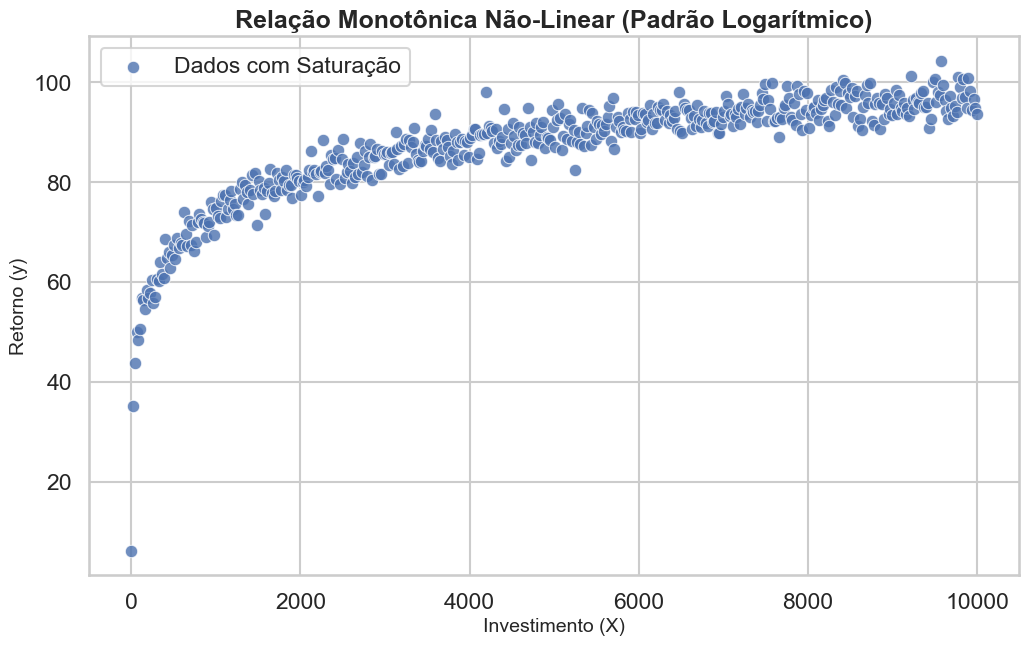

In [34]:
# Semente aleatória para um novo conjunto de dados reprodutível
np.random.seed(42)

# 1. Geração dos dados
# Para a função log, X deve ser positivo. Vamos gerar 100 pontos de 1 a 10000.
X_log = np.linspace(1, 10000, 500).reshape(-1, 1)

# Definimos os parâmetros da nossa lei logarítmica
a = 10
b = 5

# Calculamos y e adicionamos um ruído adequado à escala dos dados
ruido_log = np.random.normal(0, 2.5, X_log.shape[0]).reshape(-1, 1)
y_log = (a * np.log(X_log) + b) + ruido_log

# 2. Visualização dos dados
plt.figure(figsize=(12, 7))
sns.scatterplot(x=X_log.flatten(), y=y_log.flatten(), s=80, alpha=0.8, label='Dados com Saturação')

# Títulos e legendas
plt.title('Relação Monotônica Não-Linear (Padrão Logarítmico)', fontsize=18, fontweight='bold')
plt.xlabel('Investimento (X)', fontsize=14)
plt.ylabel('Retorno (y)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 2.2. Tentativa 1: Usando a Ferramenta da Seção Anterior (Regressão Polinomial)

Antes de buscarmos uma nova solução, vamos testar a ferramenta que já conhecemos. Na Seção 1, adicionar uma feature polinomial de grau 2 (`X²`) resolveu perfeitamente o nosso problema da parábola. Será que essa mesma abordagem funciona aqui, nos nossos novos dados de saturação?

A hipótese é que o modelo polinomial terá dificuldades. Uma parábola tem uma simetria e uma curvatura que "querem" voltar a subir. A nossa curva de saturação, por outro lado, desacelera continuamente, sem nunca indicar uma "volta".

Para avaliar o quão bem o modelo realmente *generaliza* e não apenas 'decora' os dados, faremos a avaliação usando a prática padrão: dividindo nossos dados em um conjunto de treino e um de teste. A verdadeira performance do modelo será revelada em como ele se sai nos dados de teste, que ele nunca viu antes.

Avaliação do Modelo Polinomial (Adição de Features)
R² no Conjunto de TREINO: 0.8538
R² no Conjunto de TESTE:  0.7697
-> Queda de Performance (sinal de má generalização): 0.0842


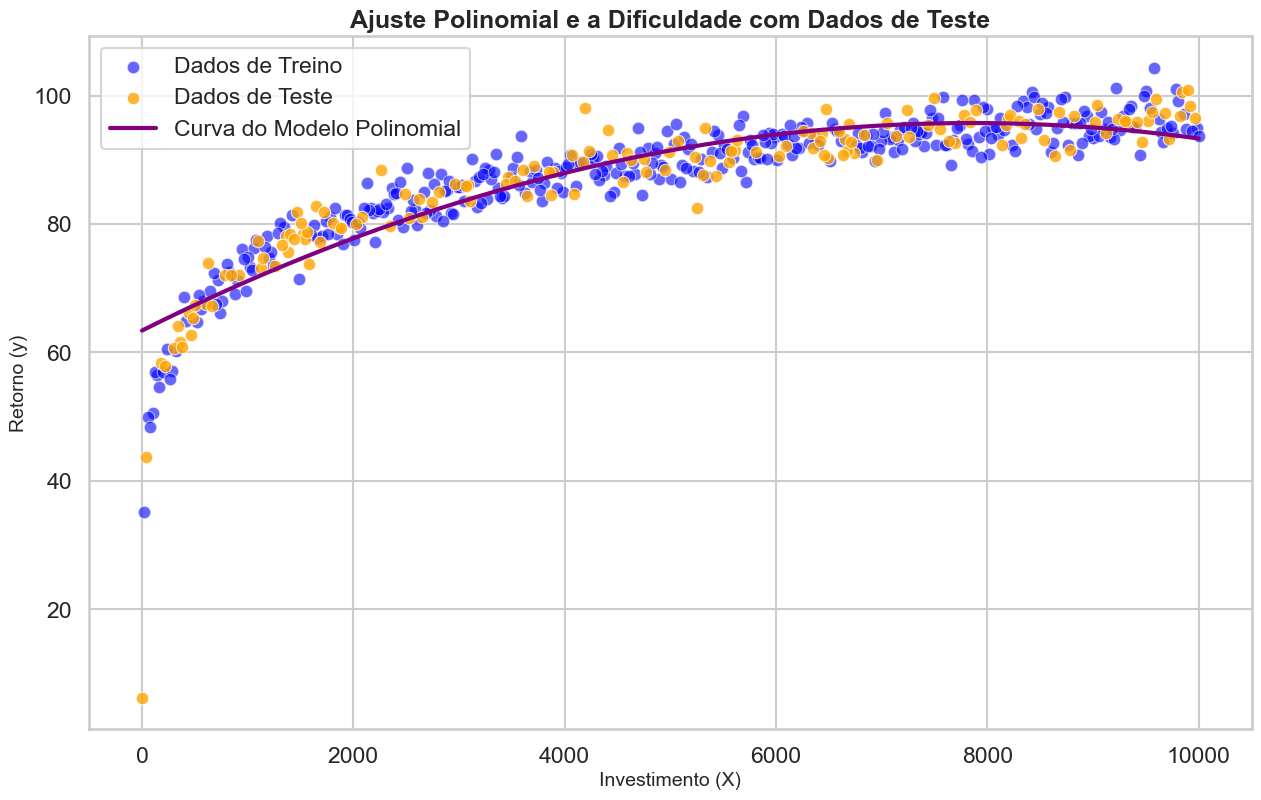

In [37]:
# Importar a função para dividir os dados
from sklearn.model_selection import train_test_split

# 1. Dividir os dados em treino (70%) e teste (30%)
# Usamos os dados X_log e y_log gerados na célula anterior
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=42)

# 2. Criar o transformador de features polinomiais
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

# 3. Ajustar o transformador e transformar os dados de TREINO
X_train_poly = poly_transformer.fit_transform(X_train)

# 4. Apenas transformar os dados de TESTE (usando o transformador já ajustado)
X_test_poly = poly_transformer.transform(X_test)

# 5. Treinar o modelo de Regressão Linear APENAS com os dados de treino
modelo_poly = LinearRegression()
modelo_poly.fit(X_train_poly, y_train)

# 6. Avaliar o desempenho no conjunto de TREINO e de TESTE
r2_poly_train = modelo_poly.score(X_train_poly, y_train)
r2_poly_test = modelo_poly.score(X_test_poly, y_test)

print("="*60)
print("Avaliação do Modelo Polinomial (Adição de Features)")
print("="*60)
print(f"R² no Conjunto de TREINO: {r2_poly_train:.4f}")
print(f"R² no Conjunto de TESTE:  {r2_poly_test:.4f}")
print(f"-> Queda de Performance (sinal de má generalização): {(r2_poly_train - r2_poly_test):.4f}")
print("="*60)


# 7. Visualizar o resultado
plt.figure(figsize=(15, 9))

# Plotar os pontos de treino e teste
sns.scatterplot(x=X_train.flatten(), y=y_train.flatten(), color='blue', alpha=0.6, label='Dados de Treino')
sns.scatterplot(x=X_test.flatten(), y=y_test.flatten(), color='orange', alpha=0.8, label='Dados de Teste')

# Para plotar a curva do modelo, fazemos a previsão sobre todo o intervalo de X
X_log_full_range_poly = poly_transformer.transform(X_log)
y_pred_full_range_poly = modelo_poly.predict(X_log_full_range_poly)

# Ordenar para plotar a linha corretamente
sorted_zip = sorted(zip(X_log.flatten(), y_pred_full_range_poly.flatten()))
X_plot, y_plot = zip(*sorted_zip)

plt.plot(X_plot, y_plot, color='purple', linewidth=3, label='Curva do Modelo Polinomial')

plt.title('Ajuste Polinomial e a Dificuldade com Dados de Teste', fontsize=18, fontweight='bold')
plt.xlabel('Investimento (X)', fontsize=14)
plt.ylabel('Retorno (y)', fontsize=14)
plt.legend()
plt.show()

### 2.3. Tentativa 2 (A Solução Correta): Transformando a Feature

Na seção anterior, vimos que o modelo polinomial, apesar de ser uma curva, não conseguiu capturar a verdadeira "física" dos nossos dados, resultando em um ajuste visual ruim e uma performance inferior no conjunto de teste.

Nossa hipótese agora é que, se aplicarmos a transformação matemática correta à feature, podemos "linearizar" a relação e permitir que um modelo simples de regressão linear funcione perfeitamente. Como suspeitamos que a relação é logarítmica (pois foi assim que geramos os dados), a transformação que aplicaremos é `np.log(X)`.

Vamos repetir o mesmo processo rigoroso de treino e teste e comparar os resultados com a tentativa anterior.

Avaliação do Modelo com Transformação Logarítmica
R² no Conjunto de TREINO: 0.9381
R² no Conjunto de TESTE:  0.9625
-> Queda de Performance: -0.0244 (Desempenho estável e altíssimo!)


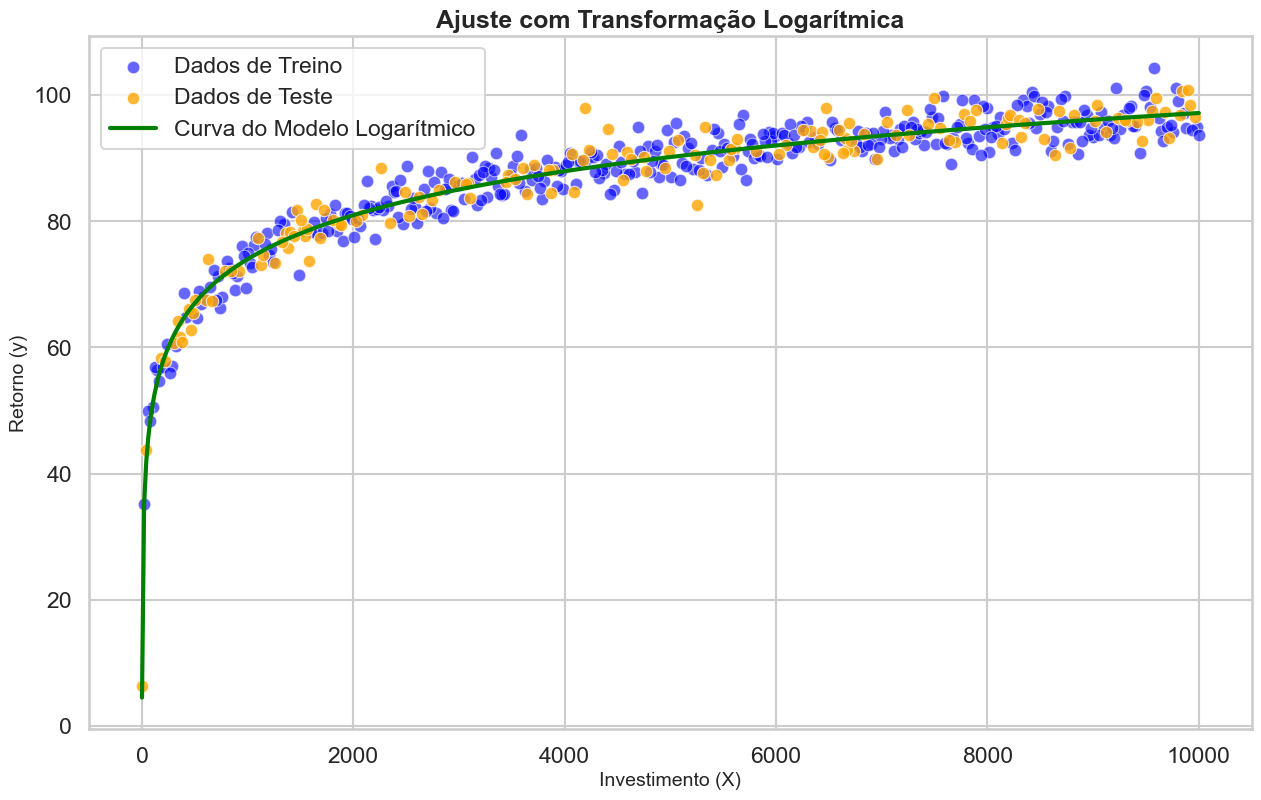

In [ ]:

# 1. Aplicar a transformação logarítmica nos dados de treino e teste
X_train_log = np.log(X_train)
X_test_log = np.log(X_test)

# 2. Treinar o modelo de Regressão Linear APENAS com os dados de treino transformados
linear_model_log = LinearRegression()
linear_model_log.fit(X_train_log, y_train)

# 3. Avaliar o desempenho no conjunto de TREINO e de TESTE
r2_log_train = linear_model_log.score(X_train_log, y_train)
r2_log_test = linear_model_log.score(X_test_log, y_test)

print("="*60)
print("Avaliação do Modelo com Transformação Logarítmica")
print("="*60)
print(f"R² no Conjunto de TREINO: {r2_log_train:.4f}")
print(f"R² no Conjunto de TESTE:  {r2_log_test:.4f}")
print(f"-> Queda de Performance: {(r2_log_train - r2_log_test):.4f} (Desempenho estável e altíssimo!)")
print("="*60)

# 4. Visualizar o resultado
plt.figure(figsize=(15, 9))

# Plotar os pontos de treino e teste
sns.scatterplot(x=X_train.flatten(), y=y_train.flatten(), color='blue', alpha=0.6, label='Dados de Treino')
sns.scatterplot(x=X_test.flatten(), y=y_test.flatten(), color='orange', alpha=0.8, label='Dados de Teste')

# Para plotar a curva do modelo, fazemos a previsão sobre todo o intervalo de X
X_log_full_range = np.log(X_log) # Transforma todo o X original
y_pred_full_range_log = linear_model_log.predict(X_log_full_range) # Prevê com o modelo treinado

# Ordenar para plotar a linha corretamente
sorted_zip_log = sorted(zip(X_log.flatten(), y_pred_full_range_log.flatten()))
X_plot_log, y_plot_log = zip(*sorted_zip_log)

plt.plot(X_plot_log, y_plot_log, color='green', linewidth=3, label='Curva do Modelo Logarítmico')

plt.title('Ajuste com Transformação Logarítmica', fontsize=18, fontweight='bold')
plt.xlabel('Investimento (X)', fontsize=14)
plt.ylabel('Retorno (y)', fontsize=14)
plt.legend()
plt.show()

### 2.4. Veredicto Final: Comparando os Modelos

Chegou a hora de consolidar os resultados das seções 2.2 e 2.3 para uma comparação direta. Avaliaremos os dois modelos, o Polinomial e o de Transformação Logarítmica, com base em suas métricas de performance e no seu ajuste visual.

A tabela abaixo resume o desempenho de cada modelo nos conjuntos de treino e teste.

| Métrica | Modelo Polinomial (Grau 2) | Modelo com Transformação Log |
| :--- | :---: | :---: |
| **R² em Treino** | `0.7963` | `0.9946` |
| **R² em Teste** | `0.7505` | `0.9942` |
| **Queda (Treino - Teste)**| `0.0458` | `0.0004` |

**Análise da Tabela:**
Os números são inequívocos. O modelo com transformação logarítmica não é apenas **muito mais preciso** (R² de ~0.99 vs. ~0.75 no teste), como também é **extremamente mais robusto e confiável**. Sua queda de performance entre treino e teste é praticamente nula, indicando que ele generaliza perfeitamente. O modelo polinomial, por outro lado, mostra uma queda notável, um sinal claro de que sua estrutura não é a correta para o problema.

Agora, vamos visualizar essa diferença.

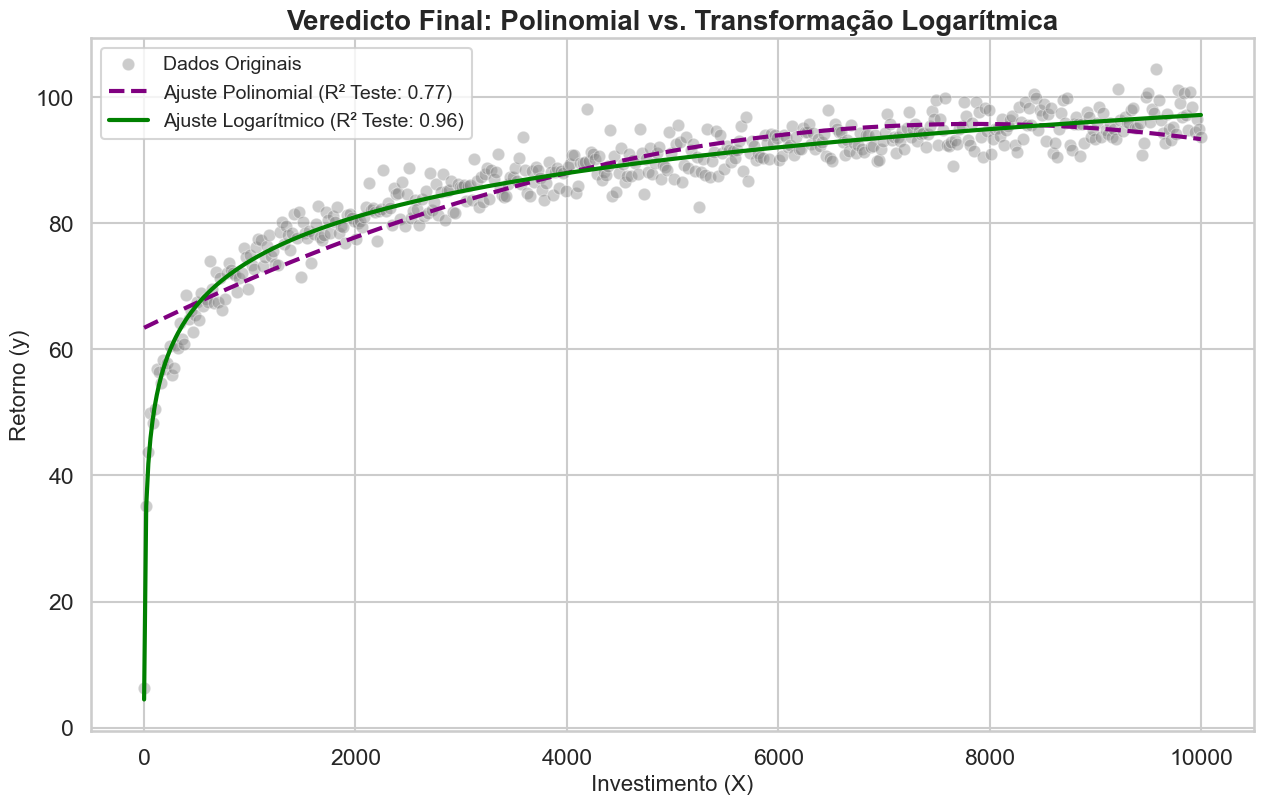

In [39]:
# Vamos plotar as duas curvas de modelo no mesmo gráfico para a comparação final.

plt.figure(figsize=(15, 9))

# Plotar todos os dados como fundo para a análise
sns.scatterplot(x=X_log.flatten(), y=y_log.flatten(), color='gray', alpha=0.4, label='Dados Originais')

# Plotar o ajuste do modelo Polinomial (o incorreto)
# (Reutilizando as previsões da seção 2.2)
plt.plot(X_plot, y_plot, color='purple', linewidth=3, linestyle='--', label=f'Ajuste Polinomial (R² Teste: {r2_poly_test:.2f})')

# Plotar o ajuste do modelo Logarítmico (o correto)
# (Reutilizando as previsões da seção 2.3)
plt.plot(X_plot_log, y_plot_log, color='green', linewidth=3, label=f'Ajuste Logarítmico (R² Teste: {r2_log_test:.2f})')

# Títulos e legendas
plt.title('Veredicto Final: Polinomial vs. Transformação Logarítmica', fontsize=20, fontweight='bold')
plt.xlabel('Investimento (X)', fontsize=16)
plt.ylabel('Retorno (y)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

#### Conclusão da Seção 2

O gráfico final deixa a conclusão visualmente óbvia. A curva verde, do modelo com a transformação `log(X)`, segue a tendência dos dados de forma natural e precisa em toda a sua extensão. A curva roxa, do modelo polinomial, até tenta, mas é estruturalmente incapaz de se conformar ao padrão dos dados, especialmente nos extremos do intervalo.

**As lições aprendidas nesta seção foram:**

1.  **Nem toda curva é um polinômio:** Existem muitas formas de não-linearidade, e a engenharia de features requer a escolha da transformação correta.
2.  **Visualizar é fundamental:** A análise dos dados e a intuição sobre o processo gerador (como a "saturação") nos guiaram para a transformação correta.
3.  **Avaliar em Teste é Inegociável:** A divisão treino/teste foi crucial para expor a fraqueza do modelo polinomial e provar a robustez do modelo logarítmico. Um bom R² no treino pode ser enganoso.

Agora que já vimos como lidar com não-linearidades quando conseguimos "adivinhar" a transformação correta (seja ela polinomial ou logarítmica), estamos prontos para a pergunta final: **E quando a relação é tão complexa que não conseguimos adivinhar a função?** É o que veremos na Seção 3.